In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None, to3d=True, splits=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the column/s where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.loc[:, data_cols].values
    _, seq_len = data.shape
    if to3d: X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    else: 
        assert feat_col is None, 'When feat_col is not None you must set to3d=True'
        X = data
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    if splits is None: return X, y
    else: return split_xy(X, y, splits)


def split_xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]

In [ ]:
#hide
#old
# def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
# #hide
# #old
# def SlidingWindow(window_length:int, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:int=0, seq_first:bool=True, 
#                   sort_by:Optional[list]=None, ascending:bool=True):

#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         y_func          = function to calculate the ys based on the get_y col/s and the last lookback window or the horizon.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
#         sort_by         = column/s used for sorting the array in ascending order
#         ascending       = used in sorting
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0:
#                     if y_func is not None:
#                         y.append(y_func(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))]))
#                     else: 
#                         y.append(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0:
#                     if y_func is not None: 
#                         y.append(y_func(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i, i + wl))]))
#                     else: 
#                         y.append(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i + wl - 1, i + wl))])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if y is not None and get_y != []:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            return X, y
        else: return X, None
    return _inner

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


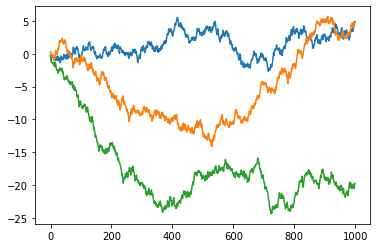

[(array([[-0.2736654 , -0.5364333 , -1.00507283, -0.89079334, -0.404512  ],
       [ 0.34022728,  0.06227114, -0.33279979, -0.60327782, -0.56538352]]), -1.321976911958261), (array([[-0.25195811, -0.22206274, -0.46793298, -0.41111057, -0.43332041],
       [-0.16171078, -0.50142245, -0.10328932, -0.33386618, -0.63210903]]), -1.5972269589386925), (array([[-0.63398496, -0.78541749, -0.94089094, -1.00413682, -0.56119463],
       [-0.83331752, -0.77376541, -1.00735304, -0.76078925, -0.8093592 ]]), -1.4982559396493702), (array([[-0.49311388, -0.57516304, -0.97216961, -0.68807705, -0.46313662],
       [-0.36082612,  0.07978909,  0.51298604,  0.30034304,  0.17366266]]), -2.3018457150415474), (array([[-0.51415746, -0.82343627, -0.96822557, -0.56114082, -0.33919652],
       [-0.06277172, -0.02347609, -0.16911636,  0.2562571 ,  0.66895859]]), -2.942464182078557), (array([[-0.65077185, -1.02227601, -0.82814815, -0.6005536 , -0.72116783],
       [ 0.8939521 ,  0.71684801,  1.0907268 ,  1.5859262 ,  

In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 3)


,var_0,var_1,target
0,0.335578,-0.405260,-0.478397
1,0.752454,-0.299195,-0.764440
2,0.751551,-0.387966,-1.104506
3,0.309118,-0.426416,-0.649204
4,-0.173265,-0.370739,-0.698202
...,...,...,...
95,0.487130,-0.348610,-4.836872
96,0.031523,-0.399391,-4.413784
97,0.527176,-0.007447,-4.035404
98,0.748973,0.452286,-4.447825


[(array([[ 0.33557762,  0.7524541 ,  0.75155139,  0.30911804, -0.17326494],
       [-0.4052603 , -0.29919492, -0.38796627, -0.42641575, -0.37073913]]), -0.6982015160208381), (array([[ 0.7524541 ,  0.75155139,  0.30911804, -0.17326494,  0.2968572 ],
       [-0.29919492, -0.38796627, -0.42641575, -0.37073913, -0.25536983]]), -0.9450262211180444), (array([[ 0.75155139,  0.30911804, -0.17326494,  0.2968572 ,  0.42689634],
       [-0.38796627, -0.42641575, -0.37073913, -0.25536983, -0.40619996]]), -1.0884131187411472), (array([[ 0.30911804, -0.17326494,  0.2968572 ,  0.42689634,  0.68266085],
       [-0.42641575, -0.37073913, -0.25536983, -0.40619996, -0.28735305]]), -1.3134870950050357), (array([[-0.17326494,  0.2968572 ,  0.42689634,  0.68266085,  0.79630719],
       [-0.37073913, -0.25536983, -0.40619996, -0.28735305, -0.49234183]]), -1.4556149214072396), (array([[ 0.2968572 ,  0.42689634,  0.68266085,  0.79630719,  0.88222496],
       [-0.25536983, -0.40619996, -0.28735305, -0.49234183,

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.310931,0.459407,0.187770,0.123054,0.336302
1,0.285633,0.453350,0.293843,-0.268234,0.729260
2,-0.135950,0.177453,-0.085374,0.054295,0.867680
3,0.062186,0.521320,-0.465628,-0.299669,0.941665
4,0.267728,0.587469,-0.034543,-0.226996,0.836485
...,...,...,...,...,...
95,8.051097,3.606151,3.722962,0.613029,-1.063008
96,8.141304,3.848417,3.263763,0.539437,-1.336112
97,8.323742,3.621845,3.218528,0.718546,-1.570941
98,8.443156,3.245462,3.436231,1.000474,-1.311723


[(array([[ 0.31093069,  0.28563283, -0.13594963,  0.06218637,  0.26772801],
       [ 0.4594073 ,  0.45334985,  0.17745327,  0.52131979,  0.58746949],
       [ 0.18777049,  0.29384297, -0.08537369, -0.46562844, -0.03454342],
       [ 0.12305397, -0.26823362,  0.05429523, -0.29966866, -0.22699616]]), 0.8364851926692621), (array([[ 0.28563283, -0.13594963,  0.06218637,  0.26772801,  0.24112549],
       [ 0.45334985,  0.17745327,  0.52131979,  0.58746949,  0.8773153 ],
       [ 0.29384297, -0.08537369, -0.46562844, -0.03454342, -0.42711134],
       [-0.26823362,  0.05429523, -0.29966866, -0.22699616, -0.5186165 ]]), 0.6525312482367915), (array([[-0.13594963,  0.06218637,  0.26772801,  0.24112549, -0.07188019],
       [ 0.17745327,  0.52131979,  0.58746949,  0.8773153 ,  1.10965729],
       [-0.08537369, -0.46562844, -0.03454342, -0.42711134, -0.4900338 ],
       [ 0.05429523, -0.29966866, -0.22699616, -0.5186165 , -0.81037422]]), 0.24585460716611363), (array([[ 0.06218637,  0.26772801,  0.

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.103905,0.120503,-0.023726,0.290820,-0.114787,0.114595,0.309597,0.662055,0.252942,0.468780,...,-0.262611,-0.187721,-0.608519,-0.604622,-0.196008,0.211910,-0.004958,-0.003140,0.359227,0.689494
var_1,-0.478806,-0.280796,-0.453873,-0.058248,-0.143762,0.026941,0.407986,0.125860,-0.045393,-0.341542,...,-1.011149,-1.488440,-1.390115,-0.957707,-1.174206,-1.349849,-1.209506,-0.971139,-1.134549,-1.388816
var_2,-0.341204,-0.180612,-0.329935,-0.381917,-0.075425,-0.029384,-0.198482,-0.208150,-0.137343,0.074302,...,-0.979248,-0.750993,-1.135734,-0.666555,-0.658329,-1.155584,-0.910246,-1.388850,-1.684454,-1.830125
var_3,0.489500,0.084927,-0.046360,0.351294,0.755617,0.426706,-0.011380,-0.092311,-0.554051,-0.237170,...,3.443342,3.581313,3.554254,3.387968,3.170751,3.400059,3.655893,3.527929,3.399967,3.560092
target,-0.038660,0.203586,0.368380,0.405124,0.641448,0.991012,0.838240,1.307546,1.753533,2.100293,...,1.676250,2.128648,2.319768,2.073197,2.292840,1.819220,1.443580,1.443637,1.206257,1.463326


[(array([[-0.10390477,  0.12050279, -0.02372572,  0.29081954, -0.11478739],
       [-0.4788057 , -0.28079614, -0.45387269, -0.05824793, -0.14376196],
       [-0.34120439, -0.18061217, -0.32993535, -0.38191742, -0.07542491],
       [ 0.48950043,  0.08492701, -0.04636009,  0.35129421,  0.75561686]]), 0.6414475468894654), (array([[ 0.12050279, -0.02372572,  0.29081954, -0.11478739,  0.11459497],
       [-0.28079614, -0.45387269, -0.05824793, -0.14376196,  0.02694119],
       [-0.18061217, -0.32993535, -0.38191742, -0.07542491, -0.02938438],
       [ 0.08492701, -0.04636009,  0.35129421,  0.75561686,  0.4267056 ]]), 0.9910117439297353), (array([[-0.02372572,  0.29081954, -0.11478739,  0.11459497,  0.30959658],
       [-0.45387269, -0.05824793, -0.14376196,  0.02694119,  0.4079859 ],
       [-0.32993535, -0.38191742, -0.07542491, -0.02938438, -0.19848164],
       [-0.04636009,  0.35129421,  0.75561686,  0.4267056 , -0.01138021]]), 0.838240239686215), (array([[ 0.29081954, -0.11478739,  0.11

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.447203,0.284774,0.208658,0.071516,0.561737,0.661106,0.298574,0.099999,0.502920,0.713244,...,3.918413,4.328061,3.847231,3.576597,3.977127,4.042448,3.925263,4.356409,4.427332,4.804650
var_1,-0.397238,-0.221444,-0.531435,-0.411872,0.031681,0.259987,0.141295,0.537188,0.199791,0.578311,...,1.734882,2.050846,2.470609,2.547119,2.722924,2.862038,2.878847,2.811296,3.304617,3.056972
var_2,0.451146,0.469104,0.435239,0.199413,0.371083,0.298299,0.772842,0.347240,0.256795,0.685867,...,-0.965702,-1.095587,-1.180513,-1.404502,-1.280574,-1.126216,-1.291204,-1.519802,-1.764918,-1.545156
var_3,-0.337670,-0.288688,0.186841,0.487547,0.098304,0.104689,0.076705,0.002068,0.491208,0.244819,...,0.146721,0.533607,0.511609,0.616659,1.025867,0.941066,0.564566,1.052289,0.962027,0.749000
target,0.294750,0.433297,0.749553,0.775225,0.629445,0.855184,1.081107,0.998989,1.003502,1.366310,...,0.293380,0.113002,-0.183466,-0.420112,-0.745630,-1.217866,-1.358164,-1.262852,-1.667535,-1.407215


[(array([[ 0.44720283,  0.28477441,  0.20865813,  0.07151563,  0.56173693],
       [-0.39723825, -0.22144378, -0.53143496, -0.41187247,  0.03168125],
       [ 0.45114615,  0.46910379,  0.43523918,  0.19941299,  0.37108256],
       [-0.33766969, -0.28868795,  0.18684095,  0.48754691,  0.09830439]]), 0.6294448416334091), (array([[0.66110643, 0.29857383, 0.09999873, 0.50292022, 0.7132439 ],
       [0.25998703, 0.14129518, 0.53718842, 0.19979135, 0.57831127],
       [0.29829906, 0.7728417 , 0.34724015, 0.25679518, 0.68586705],
       [0.10468853, 0.07670539, 0.00206758, 0.49120821, 0.24481942]]), 1.3663103115143262), (array([[ 1.17735771,  0.88685039,  0.47927023,  0.90387885,  0.8292071 ],
       [ 0.94262434,  0.68526879,  0.6781697 ,  0.26263659,  0.04948127],
       [ 0.99455325,  1.28677473,  1.64384765,  1.31998458,  1.11886775],
       [ 0.35441824,  0.2152922 ,  0.45539532,  0.2337496 , -0.09219279]]), 1.6944413310933646), (array([[ 1.12479478,  0.78476636,  0.72998279,  0.76864853

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.261674,-0.152902,0.236598,0.179810,0.342258
1,0.019135,-0.193068,0.054686,0.386836,0.449296
2,0.336355,-0.532541,-0.250253,0.624883,0.331215
3,0.722034,-0.607254,-0.046203,0.197953,0.700533
4,1.013491,-0.927619,-0.535495,0.052139,0.248219
...,...,...,...,...,...
95,1.084578,0.290226,0.984949,2.835279,-1.378774
96,1.535137,0.337253,0.540527,2.456467,-1.326233
97,1.702270,0.671941,0.987812,2.699428,-1.192710
98,1.936779,0.399542,0.964282,2.291370,-1.113528


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(df, window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        df              = pandas dataframe containing all data
        window_len      = length of lookback window
        unique_id_cols  = columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    global _key
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
    unique_id_values = df[unique_id_cols].drop_duplicates().values
    _x = []
    _y = []
    _key = []
    for i, v in enumerate(progress_bar(unique_id_values)):
        x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                 horizon=horizon, seq_first=seq_first, check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
        if x_v is not None and len(x_v) > 0: 
            _x.append(x_v)
            if return_key: _key.append([v.tolist()] * len(x_v))
            if y_v is not None and len(y_v) > 0: _y.append(y_v)
    X = concat(*_x)
    if _y != []:
        y = concat(*_y)
        for d in np.arange(1, y.ndim)[::-1]:
            if y.shape[d] == 1: y = np.squeeze(y, axis=d)
    else: y = None
    if return_key: 
        key = np.concatenate(_key)
        if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
        if return_key: return X, y, key
    else: return X, y

In [ ]:
samples = 100_000
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,time,device,target,region,index
0,16856,168560,1685600,16856,0,0,A,16856
1,60451,604492,6044902,60449,2,3,B,160453
2,58752,587520,5875200,58752,0,1,A,58752
3,39944,399422,3994202,39942,2,2,B,139946
4,63951,639492,6394902,63949,2,3,B,163953


(200004, 8)

In [ ]:
X, y = SlidingWindowPanel(df, window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2', 'index', 'device'], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)
X.shape, y.shape

((199992, 5, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(df, window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=[0, 1, 2], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)
X.shape, y.shape, key.shape

((199992, 3, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(df, window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)
X.shape, y.shape

((199992, 3, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(df, window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)
X.shape, y.shape

((199982, 3, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models